### 학습목표
1. 푸쉬 노티피케이션 타임 의사 결정 하기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
# seaborn
import seaborn as sns
COLORS = sns.color_palette()

%matplotlib inline

In [4]:
def plot_bar(df, xlabel, ylabel, title, figsize=(20, 10), color=COLORS[-1], rotation=45):
    plot = df.plot(kind='bar', color=color, figsize=figsize)
    plot.set_xlabel(xlabel, fontsize=10)
    plot.set_ylabel(ylabel, fontsize=10)
    plot.set_title(title, fontsize=12)
    plot.set_xticklabels(labels=df.index, rotation=rotation)

In [6]:
dtypes = {
    'UnitPrice': np.float32,
    'CustomerID': np.int32,
    'Quantity': np.int32
}
retail = pd.read_csv('/content/drive/MyDrive/미니프로젝트/쇼핑몰 주문 데이터를 활용한 데이터분석 Project/Data/OnlineRetailClean.csv', dtype=dtypes)
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], infer_datetime_format=True)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### 쿠폰 발송을 할때, push를 언제 보내는게 좋을까?
 - 고객에게 쿠폰 발송을 한다고 기획하고, 회의를 한다고 가정해보겠습니다. 
  - A: 쿠폰을 언제보내는게 좋을까요?
  - B: 아침에 출퇴근 시간에 보내는게 좋을까요?
  - C: 점심 먹고 졸린데 그때 보내보죠?
  - D: 흠 자기전에 스마트폰 많이 하던데 그때는 어떨까요?
  - A: 그러면 평균 시간을 내볼까요?
  - K: 아 **데이터**를 확인해보는게 맞지 않을까요? 언제 고객이 주로 주문을 하는지? 


 - 위에서 처럼 실제로 회의를 하다보면 의사결정이 본인/주변의 경험에 의해서 이뤄지는 것을 많이 볼 수 있습니다. 
 - 주문이 이뤄지는 시간을 고려하지 않고 막무가내로 보낸다면 아무 의미가 없고, 추후 같은 이벤트 발생시에도 판단 근거가 없게 됨
 - **현상태에서는 가장 많이 주문이 일어나는 시점에서 하는 것이 가장 직관적인 판단**
   - 1. 데이터로 파악
   - 2. 가설 제시
   - 3. 가설 검증
   - 4. 1-3 반복
 - 시간(hour, minute)과 주로 관련되기 때문에 역시 InvoiceDate가 중요한 feature
   

In [7]:
retail.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.3


In [8]:
order_by_hour=retail.set_index('InvoiceDate').groupby(lambda date:date.hour).count()['CustomerID']
order_by_hour
#시간별 구매량 

6         1
7       379
8      8690
9     21944
10    37997
11    49084
12    72065
13    64026
14    54118
15    45369
16    24089
17    13071
18     2928
19     3321
20      802
Name: CustomerID, dtype: int64

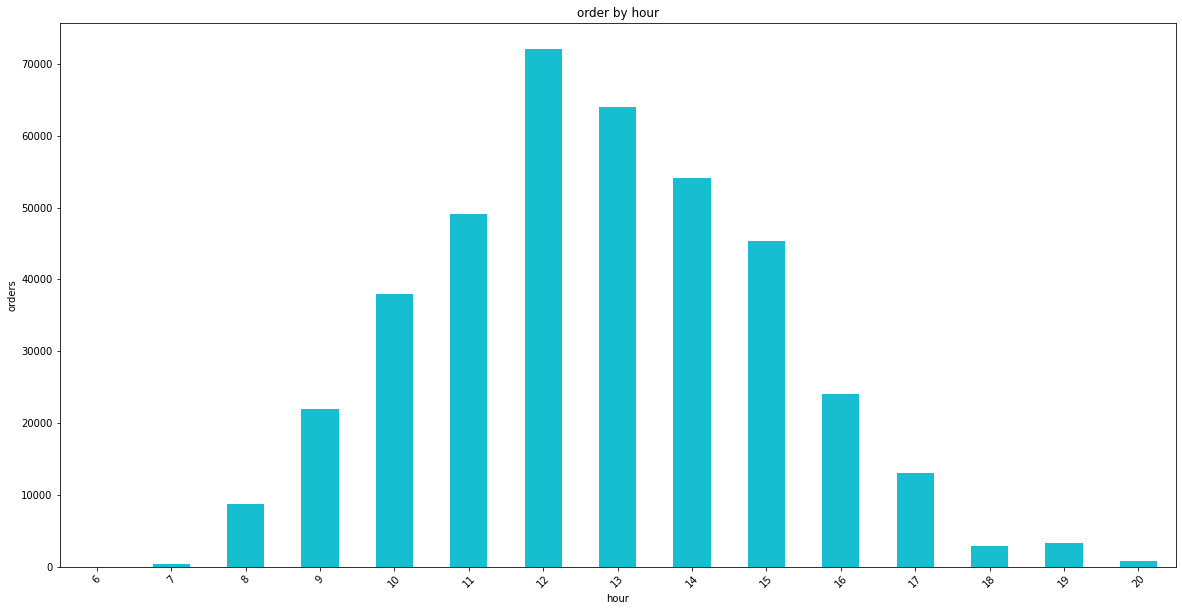

In [10]:
plot_bar(order_by_hour,'hour','orders','order by hour')
#12시 까지 증가하다가 12시 이후 감소
#최고 구매 시간 12시


#### 시간을 더 작게 쪼개서 확인(30분 단위)

In [18]:
def half_hour(date):
  minute=':00'

  if date.minute>30:
    minute=':30'
  hour=str(date.hour)
  if date.hour<10:
    hour='0'+hour

  return hour + minute

order_by_min=retail.set_index('InvoiceDate').groupby(half_hour).count()['CustomerID']
order_by_min
#30분 단위

06:00        1
07:30      379
08:00     3145
08:30     5545
09:00     9364
09:30    12580
10:00    16950
10:30    21047
11:00    18925
11:30    30159
12:00    37174
12:30    34891
13:00    31131
13:30    32895
14:00    26958
14:30    27160
15:00    24227
15:30    21142
16:00    14316
16:30     9773
17:00     8889
17:30     4182
18:00     1715
18:30     1213
19:00     1534
19:30     1787
20:00      802
Name: CustomerID, dtype: int64

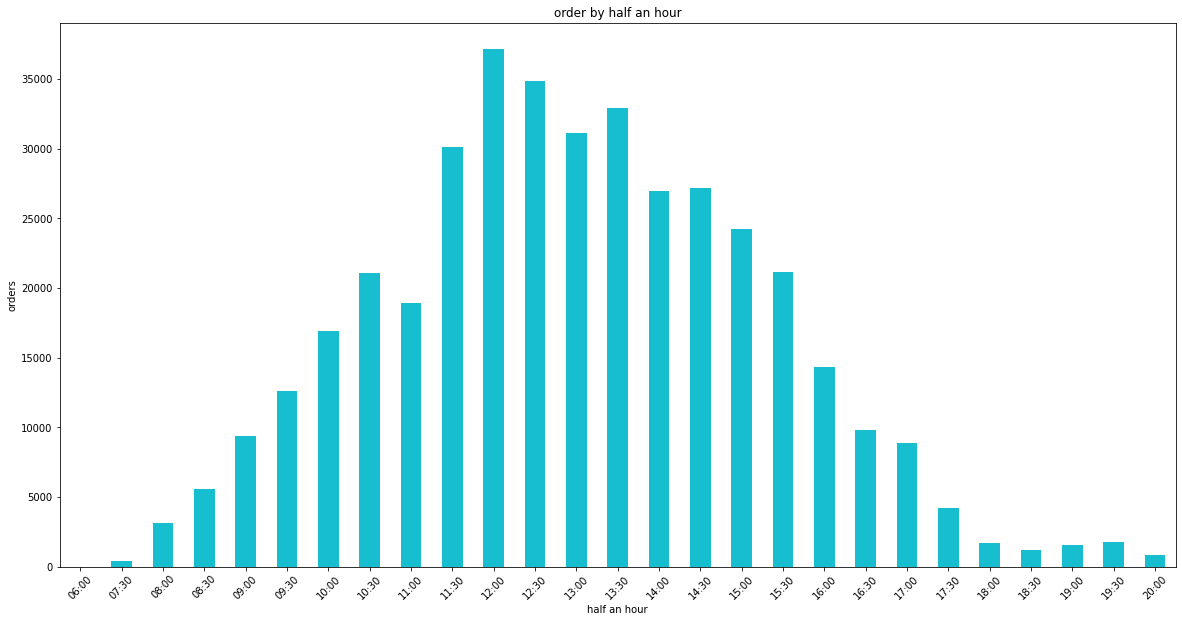

In [19]:
plot_bar(order_by_min,'half an hour','orders','order by half an hour')
#12시,12:30에 주문이 가장 많음
#주문이 많이 일어나기 10분전 정도 11시50분 12시 10분 정도에 쿠폰 발송
#그러나 12시,12:30이 많긴 하지만 전체합을 기준으로 한다면 일부분에 불과함

In [20]:
order_by_min/order_by_min.sum()
#비율
#12시와 12:30의 비율은 약 18% 나머지 82%가 더 큼

06:00    0.000003
07:30    0.000953
08:00    0.007904
08:30    0.013936
09:00    0.023534
09:30    0.031617
10:00    0.042600
10:30    0.052897
11:00    0.047564
11:30    0.075798
12:00    0.093429
12:30    0.087691
13:00    0.078241
13:30    0.082675
14:00    0.067753
14:30    0.068261
15:00    0.060890
15:30    0.053136
16:00    0.035980
16:30    0.024562
17:00    0.022341
17:30    0.010511
18:00    0.004310
18:30    0.003049
19:00    0.003855
19:30    0.004491
20:00    0.002016
Name: CustomerID, dtype: float64

#### 개인화된 push notification
 - 사용자별 많은 구매 시간대를 찾아 쿠폰 발송
 - 아마존을 필두로, **개인화(personalization)하여 맞춤으로 사용자마다 최적의 솔루션**을 찾는것이 트렌드가 됨
 - 사용자별로 소비의 패턴이 다를 수 있기 때문에, 가장 많이 구매한 시간대를 찾아서 해당 시간대에 쿠폰을 발송!

#### 사용자별 각 시간별 주문 량 계산하기

In [21]:
order_person_by_hour=retail.set_index('InvoiceDate').groupby(['CustomerID',lambda date:date.hour]).count()['StockCode']
order_person_by_hour

CustomerID    
12346       10     1
12347       8     22
            10    24
            12    47
            13    18
                  ..
18283       15     1
            16    56
            19    87
18287       9      3
            10    67
Name: StockCode, Length: 11205, dtype: int64

#### 사용자별 최대 주문 시간 계산하기
 - 가장 많은 주문량을 보인 시간을 계산

In [23]:
idx=order_person_by_hour.groupby('CustomerID').idxmax()

#### 해당 시간 indexing

In [29]:
result=order_person_by_hour.loc[idx]
result

CustomerID    
12346       10      1
12347       14     60
12348       19     17
12349       9      73
12350       16     17
                 ... 
18280       9      10
18281       10      7
18282       13      7
18283       14    201
18287       10     67
Name: StockCode, Length: 4338, dtype: int64

In [27]:
result.reset_index().groupby('level_1').groups
#사용자별 최대구매시간대 구해서 시간대별로 묶음

{7: [73, 269, 319, 344, 375, 893, 1667, 2317], 8: [46, 58, 87, 126, 172, 179, 187, 260, 278, 279, 282, 292, 306, 347, 399, 429, 496, 503, 526, 533, 549, 552, 651, 671, 747, 755, 784, 792, 800, 803, 806, 821, 838, 877, 883, 920, 944, 947, 951, 954, 1008, 1093, 1106, 1120, 1138, 1172, 1173, 1217, 1251, 1397, 1422, 1424, 1436, 1472, 1512, 1616, 1621, 1666, 1668, 1678, 1687, 1734, 1759, 1761, 1774, 1791, 1815, 1827, 1846, 1859, 1895, 1900, 1903, 1996, 2018, 2023, 2054, 2085, 2108, 2117, 2167, 2172, 2253, 2380, 2383, 2403, 2404, 2417, 2427, 2462, 2464, 2643, 2749, 2776, 2781, 2896, 2936, 2949, 3021, 3130, ...], 9: [3, 9, 26, 30, 33, 35, 37, 48, 60, 66, 75, 84, 86, 90, 100, 106, 107, 121, 127, 135, 138, 142, 144, 146, 154, 159, 181, 199, 230, 240, 264, 265, 267, 277, 280, 286, 294, 298, 328, 333, 336, 342, 343, 352, 362, 366, 385, 402, 421, 459, 470, 475, 478, 482, 483, 509, 517, 519, 574, 603, 615, 630, 636, 642, 644, 691, 701, 706, 707, 746, 749, 752, 764, 770, 781, 783, 818, 825, 829, 844